In [18]:
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_image(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((64, 64))  # Resize to a fixed size
    img_array = np.array(img)
    return img_array

# Function to load dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    for label, folder in [("MaleFaces", 0), ("FemaleFaces", 1)]:
        label_dir = os.path.join(dataset_path, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = load_image(img_path)
            images.append(img)
            labels.append(folder)
    return np.array(images), np.array(labels)

# Feature Extraction using Watershed
def extract_features(images):
    features = []
    for img in images:
        # Apply the Watershed algorithm
        ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        sure_bg = cv2.dilate(thresh, None, iterations=3)
        dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)
        features.append(np.ravel(markers))  # Flatten the feature map
    return np.array(features)

# Define the Multilayer Perceptron Model
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return z * (1 - z)
    
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1)
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2)
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    def backward(self, X, y, output):
        error_output = y - output
        dW2 = np.dot(self.A1.T, error_output * self.sigmoid_derivative(output))
        error_hidden = np.dot(error_output * self.sigmoid_derivative(output), self.W2.T)
        dW1 = np.dot(X.T, error_hidden * self.sigmoid_derivative(self.A1))
        
        self.W1 += self.learning_rate * dW1
        self.W2 += self.learning_rate * dW2
    
    def train(self, X, y, epochs=1000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = np.mean((y - output) ** 2)
            losses.append(loss)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
        return losses

# Plot the loss function
def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


In [19]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_image(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((64, 64))  # Resize to a fixed size
    img_array = np.array(img)
    return img_array

# Function to load dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    for label, folder in [("MaleFaces", 0), ("FemaleFaces", 1)]:
        label_dir = os.path.join(dataset_path, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = load_image(img_path)
            images.append(img)
            labels.append(folder)
    return np.array(images), np.array(labels)

# Feature Extraction using Watershed
def extract_features(images):
    features = []
    for img in images:
        # Apply the Watershed algorithm
        ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        sure_bg = cv2.dilate(thresh, None, iterations=3)
        dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)
        features.append(np.ravel(markers))  # Flatten the feature map
    return np.array(features)

# Define the Multilayer Perceptron Model
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return z * (1 - z)
    
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1)
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2)
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    def backward(self, X, y, output):
        error_output = y - output
        dW2 = np.dot(self.A1.T, error_output * self.sigmoid_derivative(output))
        error_hidden = np.dot(error_output * self.sigmoid_derivative(output), self.W2.T)
        dW1 = np.dot(X.T, error_hidden * self.sigmoid_derivative(self.A1))
        
        self.W1 += self.learning_rate * dW1
        self.W2 += self.learning_rate * dW2
    
    def train(self, X, y, epochs=1000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = np.mean((y - output) ** 2)
            losses.append(loss)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
        return losses

# Plot the loss function
def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 0, Loss: 0.47908816041602886
Epoch 100, Loss: 0.48459325771248635
Epoch 200, Loss: 0.3726007309209226
Epoch 300, Loss: 0.30846251956650805
Epoch 400, Loss: 0.3422089083019127
Epoch 500, Loss: 0.17853476600000903
Epoch 600, Loss: 0.12679665443443372
Epoch 700, Loss: 0.24695761214703335
Epoch 800, Loss: 0.2622253679051873
Epoch 900, Loss: 0.17245710968513064


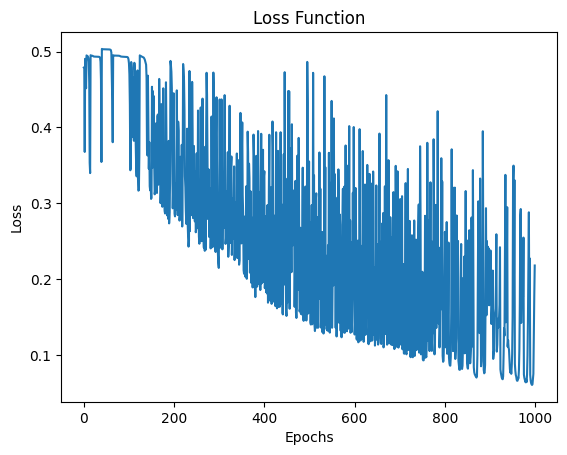

Accuracy: 88.28%
Epoch 0, Loss: 0.4161341684331503
Epoch 100, Loss: 0.49861557459363337
Epoch 200, Loss: 0.49861557447721777
Epoch 300, Loss: 0.4986155743596237
Epoch 400, Loss: 0.4986155742408331
Epoch 500, Loss: 0.498615574120828
Epoch 600, Loss: 0.4986155739995897
Epoch 700, Loss: 0.4986155738770992
Epoch 800, Loss: 0.4986155737533372
Epoch 900, Loss: 0.4986155736282838


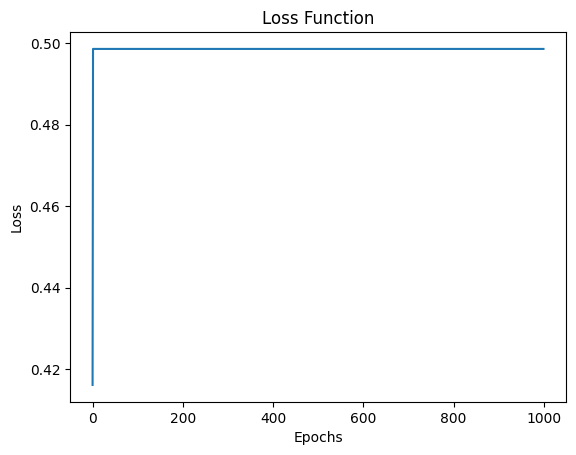

Accuracy: 48.43%
Epoch 0, Loss: 0.3499660779185542
Epoch 100, Loss: 0.5032300895926424
Epoch 200, Loss: 0.5032300845160895
Epoch 300, Loss: 0.5032300791494241
Epoch 400, Loss: 0.5032300734670506
Epoch 500, Loss: 0.5032300674402725
Epoch 600, Loss: 0.5032300610368067
Epoch 700, Loss: 0.5032300542202061
Epoch 800, Loss: 0.5032300469491656
Epoch 900, Loss: 0.5032300391766846


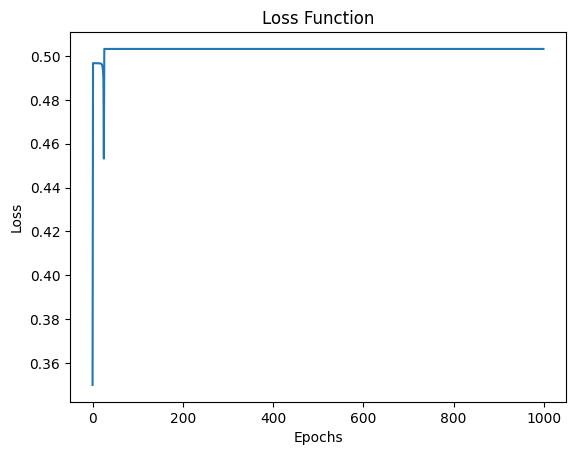

Accuracy: 50.28%
Epoch 0, Loss: 0.3790626925317353
Epoch 100, Loss: 0.49642439840350017
Epoch 200, Loss: 0.4964243979951922
Epoch 300, Loss: 0.49642439758055557
Epoch 400, Loss: 0.49642439715944087
Epoch 500, Loss: 0.4964243967316947
Epoch 600, Loss: 0.49642439629715795
Epoch 700, Loss: 0.4964243958556668
Epoch 800, Loss: 0.49642439540705197
Epoch 900, Loss: 0.49642439495113894


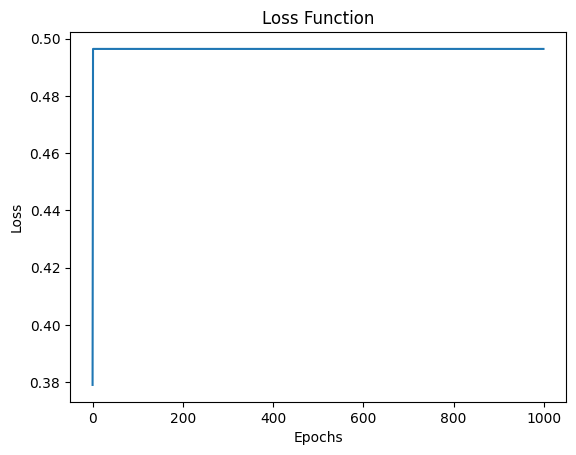

Accuracy: 49.58%
Epoch 0, Loss: 0.49877064365692575
Epoch 100, Loss: 0.4994221879238353
Epoch 200, Loss: 0.49942196871172345
Epoch 300, Loss: 0.49942164166956804
Epoch 400, Loss: 0.49942110133167933
Epoch 500, Loss: 0.49942003835530324
Epoch 600, Loss: 0.49941698846083316
Epoch 700, Loss: 0.4993381587517183
Epoch 800, Loss: 0.49942329873124286
Epoch 900, Loss: 0.49942329873124286


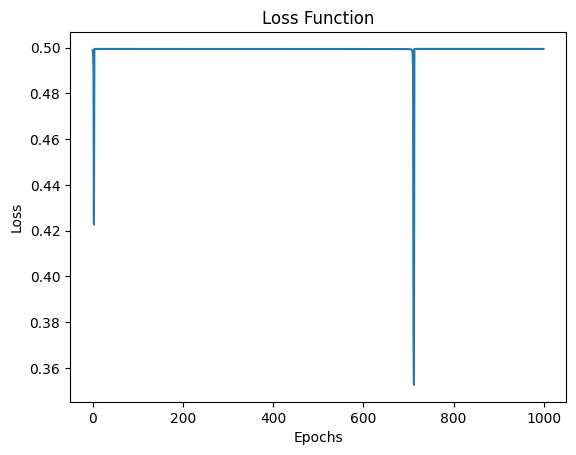

Accuracy: 50.78%
Average Accuracy: 57.47%


In [ ]:
# Plot the loss function
def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Load and prepare dataset
dataset_path = "./MaleandFemalefacedataset"

images, labels = load_dataset(dataset_path)
images = extract_features(images)

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)
accuracies = []

for train_index, test_index in kfold.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Normalize data
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)

    # Train the MLP
    input_size = X_train.shape[1]
    hidden_size = 128
    output_size = 1  # Binary classification

    model = SimpleMLP(input_size, hidden_size, output_size)
    losses = model.train(X_train, y_train.reshape(-1, 1), epochs=1000)

    # Plot loss function
    plot_loss(losses)

    # Test model
    y_pred = model.forward(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Average Accuracy: {np.mean(accuracies) * 100:.2f}%")